In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:


# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

from random import *
from tqdm.notebook import tqdm, trange
from time import sleep
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from warnings import filterwarnings
filterwarnings('ignore')
from torch.utils.data import random_split

In [2]:
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    plt.savefig('labels.JPG')
    
    
batch_size = 32
num_classes = 7
learning_rate = 0.01
num_epochs = 5

In [4]:
train_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

test_trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
        )
])

In [5]:
## Load data
from torchvision.datasets import ImageFolder
data = ImageFolder("D:\\SPRING 2023\\MS_Thesis\\MASTER'S THESIS\\Thesis results\\Data\\Data_Structure(Annotated)", transform=train_trans , )
test_folder= ImageFolder("D:\\SPRING 2023\\MS_Thesis\\MASTER'S THESIS\\Thesis results\\Data\\Data_Structure(Raw images)", transform=test_trans, )


## hyperparameters

batch_size = 64
num_classes = 4
learning_rate = 0.0001
num_epochs = 1000

print("Follwing classes are there : \n",data.classes)


print("data length:", len(data))

classes = ('Alligator Cracks', 'Delamination', 'Longitudinal Cracks', 'Transverse Cracks')

##Splitting Data and Prepare Batches: 
## Source: https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48 
val_size = 127 ##  Tamim:30% data for validation ## 
train_size = len(data) - val_size 

## To randomly split the images into training and testing, PyTorch provides random_split()
train_data, val_data = random_split(data,[train_size,val_size]) 
print(f"Length of Train Data : {len(train_data)}")     ## changed the folder names
print(f"Length of Validation Data : {len(val_data)}")

# Splitting train and validation data on batches

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size) ## defined train data & val data
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_folder, shuffle=False, batch_size=batch_size)

Follwing classes are there : 
 ['Alligator Cracks', 'Delamination', 'Longitudinal Cracks', 'Transverse Cracks']
data length: 424
Length of Train Data : 297
Length of Validation Data : 127


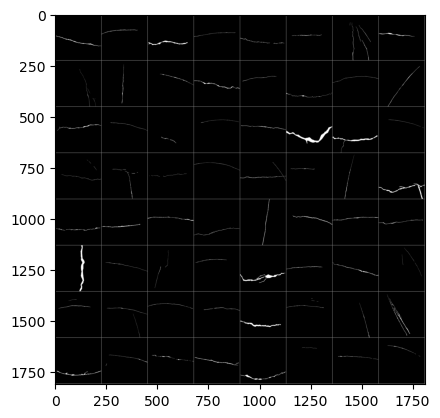

Transverse Cracks Transverse Cracks Delamination Transverse Cracks Transverse Cracks Transverse Cracks Alligator Cracks Transverse Cracks Longitudinal Cracks Longitudinal Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Longitudinal Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Delamination Delamination Transverse Cracks Transverse Cracks Alligator Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Longitudinal Cracks Delamination Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Longitudinal Cracks Transverse Cracks Transverse Cracks Transverse Cracks Delamination Transverse Cracks Longitudinal Cracks Transverse Cracks Delamination Transverse Cracks Transverse Cracks Longitudinal Cracks Transverse Cracks Transverse Cracks Transverse Cracks Transverse Cracks Delamination Transverse Cracks Longitudinal Cracks Alligator Cracks Transverse Cra

<Figure size 640x480 with 0 Axes>

In [6]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
# Author: Yahui Liu <yahui.liu@uintn.it>

import torch
import numpy as np
import itertools
from .base_model import BaseModel
from .deepcrack_networks import define_deepcrack, BinaryFocalLoss

class DeepCrackModel(BaseModel):
    """
    This class implements the DeepCrack model.
    DeepCrack paper: https://www.sciencedirect.com/science/article/pii/S0925231219300566
    """
    @staticmethod
    def modify_commandline_options(parser, is_train=True):
        """Add new dataset-specific options, and rewrite default values for existing options."""
        parser.add_argument('--lambda_side', type=float, default=1.0, help='weight for side output loss')
        parser.add_argument('--lambda_fused', type=float, default=1.0, help='weight for fused loss')
        return parser

    def __init__(self, opt):
        """Initialize the DeepCrack class.
        Parameters:
            opt (Option class)-- stores all the experiment flags; needs to be a subclass of BaseOptions
        """
        BaseModel.__init__(self, opt)
        # specify the training losses you want to print out. The training/test scripts will call <BaseModel.get_current_losses>
        self.loss_names = ['side', 'fused', 'total']
        # specify the images you want to save/display. The training/test scripts will call <BaseModel.get_current_visuals>
        self.display_sides = opt.display_sides
        self.visual_names = ['image', 'label_viz', 'fused']
        if self.display_sides:
            self.visual_names += ['side1', 'side2', 'side3', 'side4', 'side5']
        # specify the models you want to save to the disk. 
        self.model_names = ['G']

        # define networks 
        self.netG = define_deepcrack(opt.input_nc, 
                                     opt.num_classes, 
                                     opt.ngf, 
                                     opt.norm,
                                     opt.init_type, 
                                     opt.init_gain, 
                                     self.gpu_ids)

        self.softmax = torch.nn.Softmax(dim=1)

        if self.isTrain:
            # define loss functions
            #self.weight = torch.from_numpy(np.array([0.0300, 1.0000], dtype='float32')).float().to(self.device)
            #self.criterionSeg = torch.nn.CrossEntropyLoss(weight=self.weight)
            if self.opt.loss_mode == 'focal':
                self.criterionSeg = BinaryFocalLoss()
            else: 
                self.criterionSeg = nn.BCEWithLogitsLoss(size_average=True, reduce=True, 
                    pos_weight=torch.tensor(1.0/3e-2).to(self.device))
            self.weight_side = [0.5, 0.75, 1.0, 0.75, 0.5]

            # initialize optimizers; schedulers will be automatically created by function <BaseModel.setup>.
            self.optimizer = torch.optim.SGD(self.netG.parameters(), lr=opt.lr, momentum=0.9, weight_decay=2e-4)
            self.optimizers.append(self.optimizer)

    def set_input(self, input):
        """Unpack input data from the dataloader and perform necessary pre-processing steps.
        Parameters:
            input (dict): include the data itself and its metadata information.
        """
        self.image = input['image'].to(self.device)
        self.label = input['label'].to(self.device)
        #self.label3d = self.label.squeeze(1)
        self.image_paths = input['A_paths']

    def forward(self):
        """Run forward pass; called by both functions <optimize_parameters> and <test>."""
        self.outputs = self.netG(self.image)

        # for visualization
        self.label_viz = (self.label.float()-0.5)/0.5
        #self.fused = (self.softmax(self.outputs[-1])[:,1].detach().unsqueeze(1)-0.5)/0.5
        #if self.display_sides:
        #    self.side1 = (self.softmax(self.outputs[0])[:,1].detach().unsqueeze(1)-0.5)/0.5
        #    self.side2 = (self.softmax(self.outputs[1])[:,1].detach().unsqueeze(1)-0.5)/0.5
        #    self.side3 = (self.softmax(self.outputs[2])[:,1].detach().unsqueeze(1)-0.5)/0.5
        #    self.side4 = (self.softmax(self.outputs[3])[:,1].detach().unsqueeze(1)-0.5)/0.5
        #    self.side5 = (self.softmax(self.outputs[4])[:,1].detach().unsqueeze(1)-0.5)/0.5
        self.fused = (torch.sigmoid(self.outputs[-1])-0.5)/0.5
        if self.display_sides:
            self.side1 = (torch.sigmoid(self.outputs[0])-0.5)/0.5
            self.side2 = (torch.sigmoid(self.outputs[1])-0.5)/0.5
            self.side3 = (torch.sigmoid(self.outputs[2])-0.5)/0.5
            self.side4 = (torch.sigmoid(self.outputs[3])-0.5)/0.5
            self.side5 = (torch.sigmoid(self.outputs[4])-0.5)/0.5

    def backward(self):
        """Calculate the loss"""
        lambda_side = self.opt.lambda_side
        lambda_fused = self.opt.lambda_fused

        self.loss_side = 0.0
        for out, w in zip(self.outputs[:-1], self.weight_side):
            #self.loss_side += self.criterionSeg(out, self.label3d) * w
            self.loss_side += self.criterionSeg(out, self.label) * w

        #self.loss_fused = self.criterionSeg(self.outputs[-1], self.label3d)
        self.loss_fused = self.criterionSeg(self.outputs[-1], self.label)
        self.loss_total = self.loss_side * lambda_side + self.loss_fused * lambda_fused
        self.loss_total.backward()

    def optimize_parameters(self, epoch=None):
        """Calculate losses, gradients, and update network weights; called in every training iteration"""
        # forward
        self.forward()      # compute predictions.
        self.optimizer.zero_grad()  # set G's gradients to zero
        self.backward()             # calculate gradients for G
        self.optimizer.step()       # update G's weights

ImportError: attempted relative import with no known parent package